In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ライブラリのインポート(globライブラリを用いてファイル検索)
import glob

#フォルダの名前は？
folder_name = "A"

# ファイル一覧を取得
glob.glob('/content/drive/MyDrive/classification/content/*')
images = glob.glob('/content/drive/MyDrive/classification/content/'+folder_name+'/*.jpg')

# ファイル名を確認(先頭3枚)
print(images[:3])

['/content/drive/MyDrive/classification/content/A/case104.jpg', '/content/drive/MyDrive/classification/content/A/case1.jpg', '/content/drive/MyDrive/classification/content/A/case100.jpg']


filename:/content/drive/MyDrive/classification/content/A/case104.jpg, size:(224, 224)


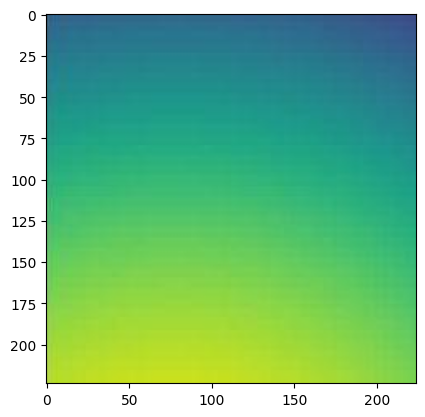

In [ ]:
# 画像表示に必要なモジュールをインポート
import matplotlib.pyplot as plt
from PIL import Image

# 画像の表示
image_sample = images[0]
img = Image.open(image_sample)
print('filename:{}, size:{}'.format(image_sample, img.size))
plt.imshow(img)
plt.show()

一連の流れを実行するためにフォルダを作成．dogを正常ラベルとする

In [ ]:
import os
import shutil
#昔にあったフォルダを削除する
shutil.rmtree('/content/images/train/')
shutil.rmtree('/content/images/val/')
shutil.rmtree('/content/images/test/')

# train用フォルダ作成
os.makedirs('/content/images/train/dog', exist_ok=True)
os.makedirs('/content/images/train/cat', exist_ok=True)

# val用フォルダ作成
os.makedirs('/content/images/val/dog', exist_ok=True)
os.makedirs('/content/images/val/cat', exist_ok=True)

# test用フォルダ作成
os.makedirs('/content/images/test/dog', exist_ok=True)
os.makedirs('/content/images/test/cat', exist_ok=True)

In [ ]:
# 犬・猫ごとのファイルパス一覧を取得
images_dog = glob.glob('/content/drive/MyDrive/classification/content/'+folder_name+'/normal'+'*.jpg')
images_cat = glob.glob('/content/drive/MyDrive/classification/content/'+folder_name+'/case'+'*jpg')
print(len(images_dog))
print(len(images_cat))

544
530


In [ ]:
# ファイルを分割(train, val, test)
idx_test_start = int(len(images_cat) * 0.8)
idx_val_start = int(idx_test_start * 0.8)

images_train_dog = images_dog[:idx_val_start]
images_train_cat = images_cat[:idx_val_start]

images_val_dog = images_dog[idx_val_start:idx_test_start]
images_val_cat = images_cat[idx_val_start:idx_test_start]

images_test_dog = images_dog[idx_test_start:]
images_test_cat = images_cat[idx_test_start:]

In [ ]:
import shutil

# 一括でファイルを移動する関数を作成
def move_files(file_list, target_dir):
    for file in file_list:
        shutil.move(file, target_dir)

# ファイル移動
move_files(images_train_dog, '/content/images/train/dog/')
move_files(images_train_cat, '/content/images/train/cat/')
move_files(images_val_dog, '/content/images/val/dog/')
move_files(images_val_cat, '/content/images/val/cat/')
move_files(images_test_dog, '/content/images/test/dog/')
move_files(images_test_cat, '/content/images/test/cat/')

In [ ]:
#分類するクラス
classes = ['cat', 'dog']
nb_classes = len(classes)

# データのディレクトリ
train_data_dir = '/content/images/train'
validation_data_dir = '/content/images/val'
test_data_dir = '/content/images/test'

# 学習回数
epochs = 20

# バッチサイズ
batch_size = 16

# 画像サイズ
img_width, img_height = 224, 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 学習データのImageDataGenerator作成
train_datagen = ImageDataGenerator(rescale=1.0 / 255)  # rescaleで各画素のスケールを0～255から0～1に変換
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size
)

Found 678 images belonging to 2 classes.


In [ ]:
# 検証データのImageDataGenerator作成
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = validation_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size
)

Found 170 images belonging to 2 classes.


In [ ]:
# 評価データのImageDataGenerator作成
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    shuffle=False  # シャッフルしない
)

Found 226 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense

input_tensor = Input(shape=(img_width, img_height, 3))
VGG16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
# VGG16のパラメータを凍結(すべての層を凍結)
for layer in VGG16.layers:
    layer.trainable = False

In [ ]:
# 差し替え用の新しい層を追加
model = Sequential()
model.add(VGG16)
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))

In [ ]:
print(folder_name)
model.summary()

A
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [ ]:
# 学習
steps_per_epoch = int(len(train_generator.classes) / batch_size)
history = model.fit(
    x=train_generator,  # 学習データ
    steps_per_epoch=steps_per_epoch,  # ステップ数
    epochs=epochs,  # エポック数
    validation_data=validation_generator  # 検証データ
)

Epoch 1/20
42/42 [==============================] - 12s 157ms/step - loss: 0.9835 - accuracy: 0.5151 - val_loss: 0.7786 - val_accuracy: 0.5059
Epoch 2/20
42/42 [==============================] - 3s 82ms/step - loss: 0.7311 - accuracy: 0.5000 - val_loss: 0.6955 - val_accuracy: 0.5059
Epoch 3/20
42/42 [==============================] - 3s 82ms/step - loss: 0.7594 - accuracy: 0.5045 - val_loss: 0.8321 - val_accuracy: 0.5059
Epoch 4/20
42/42 [==============================] - 3s 81ms/step - loss: 0.8096 - accuracy: 0.4683 - val_loss: 0.7452 - val_accuracy: 0.5059
Epoch 5/20
42/42 [==============================] - 3s 82ms/step - loss: 0.8536 - accuracy: 0.4864 - val_loss: 0.8754 - val_accuracy: 0.5000
Epoch 6/20
42/42 [==============================] - 4s 96ms/step - loss: 0.8120 - accuracy: 0.5076 - val_loss: 0.9181 - val_accuracy: 0.5000
Epoch 7/20
42/42 [==============================] - 3s 81ms/step - loss: 0.7695 - accuracy: 0.5287 - val_loss: 0.8377 - val_accuracy: 0.5000
Epoch 8/20


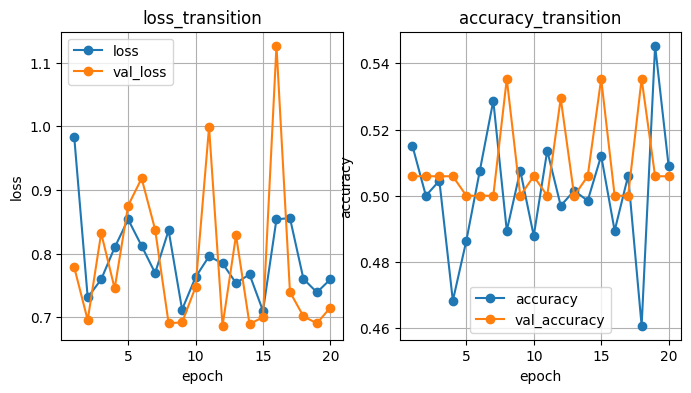

In [ ]:
# グラフ描画(2画面)
plt.figure(figsize=(8, 4))

# epochごとのlossを表示
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history.history['loss'], '-o')
plt.plot(range(1, epochs+1), history.history['val_loss'], '-o')
plt.title('loss_transition')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='best')

# epochごとのaccuracyを表示
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history.history['accuracy'], '-o')
plt.plot(range(1, epochs+1), history.history['val_accuracy'], '-o')
plt.title('accuracy_transition')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='best')

# グラフ表示
plt.show()

In [ ]:
print(folder_name)
model.evaluate(test_generator)

A
8/8 [==============================] - 6s 211ms/step - loss: 0.7473 - accuracy: 0.4646


[0.7472846508026123, 0.4646017551422119]

In [ ]:
# 正解のラベル一覧を作成。
true = test_generator.classes
true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# 予測のラベル一覧を作成
import numpy as np
p = model.predict(test_generator)
pred = np.argmax(p, axis=1)
pred

8/8 [==============================] - 1s 120ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
# 混同行列表示
from tensorflow.math import confusion_matrix
confusion_matrix(true, pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[105,   1],
       [120,   0]], dtype=int32)>

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(folder_name)
print('precision:', precision_score(true, pred))
print('recall:', recall_score(true, pred))
print('f1_score:', f1_score(true, pred))

A
precision: 0.0
recall: 0.0
f1_score: 0.0
